In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import imageio
import requests as r
import pandas as pd
import numpy as np
import h5py
import random

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras

In [ ]:
train_df = pd.read_csv('drive/MyDrive/train.csv')
train_df['timestamp'] = pd.to_datetime(train_df['Unnamed: 0'])
train_df = train_df.set_index('timestamp')


In [ ]:
f = h5py.File('drive/MyDrive/images.h5','r')
train_images = f['train'][:]
f.close()

In [ ]:
sample_map = imageio.imread('drive/MyDrive/SampleUKMap.png')

719.25

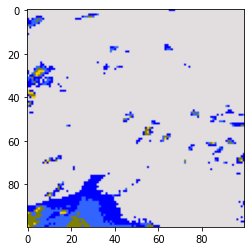

In [ ]:
# Define maps from the values in images.h5 to both colours and the estimated rain values

colour_map = np.array([
    [199,191,193,128],  
    [0,0,0,0],
    [  0,   0, 254, 255],
    [ 50, 101, 254, 255],
    [127, 127,   0, 255],
    [254, 203,   0, 255],
    [254, 152,   0, 255],
    [254,   0,   0, 255],
    [254,   0, 254, 255],
    [229, 254, 254, 255]
])

rain_map = np.array([0, 0, 0.3, 0.75, 1.5, 3, 6, 12, 24, 32])

image_idx = 25
plt.imshow(colour_map[train_images[image_idx,:,:]]) # plot 2D image of a single radar image
rain_map[train_images[image_idx,:,:]].sum() # find the total amount of rain in that radar image
# 

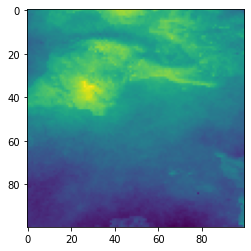

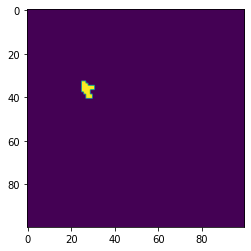

Number of pixels 30


In [ ]:
# Create a mask for the dart catchment by looking at correlation between pixels in the radar and river level (with a delay applied)

from scipy.stats.stats import pearsonr   
delay = 4*4 # 4 hours and 4 timesteps per hour
corrs = np.zeros((100, 100))

for i in range(0, 100):
  for j in range(0, 100):
    corr, _ = pearsonr(train_df.level[delay:], train_images[:-delay, i, j])
    corrs[i, j] = corr

plt.imshow(corrs)
plt.show()
dart_catchment_mask = corrs > 0.42

plt.imshow(dart_catchment_mask)
plt.show()
print("Number of pixels", dart_catchment_mask.sum())



In [ ]:
raw_X = train_images[:,dart_catchment_mask] # use the dart mask to pull out the pixels we care about
raw_Y = train_df.level.values

print(raw_X.shape)
print(raw_Y.shape)

(23511, 30)
(23511,)


In [ ]:
parameters = {
    "num_steps": 80,
    "batch_size": 150,
    "state_size": 15,
    "learning_rate": 0.1,
    "num_epochs": 10,
    "num_features": 3,
    "epoch_size": 200,
    "num_layers": 1,
    "num_level_updates": 40,
    "rain_threshold": 0
}

def sample_generator(raw_X, raw_Y, num_level_updates, num_steps, rain_threshold, batch_size):
    while True:
      X = []
      Y = []
      while len(X) < batch_size:
          i = random.randint(0, raw_X.shape[0] - num_steps)
          x = raw_X[i: i+num_steps]

          # This means we get fewer samples with no rain
          if np.sum(x) < rain_threshold:
              if random.randint(0, 10) > 4:
                  continue


          y = raw_Y[i: i+num_steps]
          update_vector = np.zeros(num_steps)
          update_vector[0:num_level_updates] = 1
          x = np.column_stack([x, update_vector, update_vector*y])
          y = np.column_stack([y])

          x = np.array(x)
          y = np.array(y)
          X.append(x)
          Y.append(y)
      X = np.stack(X)
      Y = np.stack(Y)
      yield (X, Y)

In [ ]:
dataset = tf.data.Dataset.from_generator(
    sample_generator,
    output_types = (tf.float64, tf.float64),
    output_shapes=(tf.TensorShape((parameters["batch_size"], parameters["num_steps"], dart_catchment_mask.sum()+2)), tf.TensorShape((parameters["batch_size"], parameters["num_steps"], 1))),
    args = [raw_X, raw_Y, parameters["num_level_updates"], parameters["num_steps"], parameters["rain_threshold"], parameters["batch_size"]]
)

In [ ]:
data = list(dataset.take(3).as_numpy_iterator())
print(data[0][0].shape)
print(data[0][1].shape)

(150, 80, 32)
(150, 80, 1)


In [ ]:
model = tf.keras.Sequential()

model.add(layers.LSTM(parameters['state_size'], return_sequences=True))
model.add(layers.Dense(1))

#model.summary()

In [ ]:
model.compile(optimizer=keras.optimizers.Adagrad(),
              # Loss function to minimize
              loss=keras.losses.MeanSquaredError()
              # List of metrics to monitor
              #metrics=['sparse_categorical_accuracy']
             )

In [ ]:
history = model.fit(dataset, epochs=100, steps_per_epoch=20)

Epoch 1/100
20/20 [==============================] - 2s 38ms/step - loss: 0.2325
Epoch 2/100
20/20 [==============================] - 1s 35ms/step - loss: 0.1765
Epoch 3/100
20/20 [==============================] - 1s 35ms/step - loss: 0.1476
Epoch 4/100
20/20 [==============================] - 1s 35ms/step - loss: 0.1371
Epoch 5/100
20/20 [==============================] - 1s 35ms/step - loss: 0.1256
Epoch 6/100
20/20 [==============================] - 1s 34ms/step - loss: 0.1178
Epoch 7/100
20/20 [==============================] - 1s 37ms/step - loss: 0.1125
Epoch 8/100
20/20 [==============================] - 1s 36ms/step - loss: 0.1044
Epoch 9/100
20/20 [==============================] - 1s 35ms/step - loss: 0.1022
Epoch 10/100
20/20 [==============================] - 1s 35ms/step - loss: 0.0970
Epoch 11/100
20/20 [==============================] - 1s 35ms/step - loss: 0.0947
Epoch 12/100
20/20 [==============================] - 1s 35ms/step - loss: 0.0960
Epoch 13/100
20/20 [=====

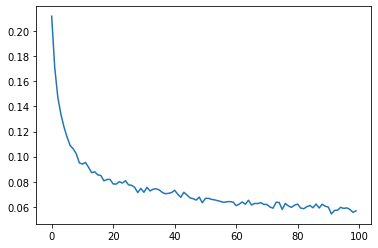

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
# find an index that gives us some decent rain
rain_threshold = 0.1
while True:
    i = random.randint(0, raw_X.shape[0] - parameters['num_steps'])
    x = raw_X[i: i+parameters['num_steps']]

    if np.sum(x) > parameters['num_steps']:
        break
y = raw_Y[i: i+parameters['num_steps']]
x = raw_X[i: i+parameters['num_steps']]
update_vector = np.zeros(parameters['num_steps'])
update_vector[0:parameters['num_level_updates']] = 1
x = np.column_stack([x, update_vector, update_vector*y])
x = np.expand_dims(x, axis=0)
radar_rain = raw_X[i: i + parameters['num_steps']].mean(axis=1)
dartcom_rain = train_df.rain.values[i: i+parameters['num_steps']]


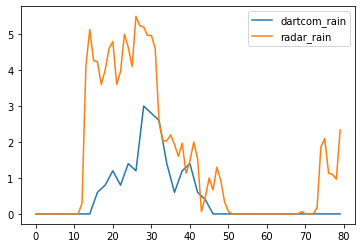

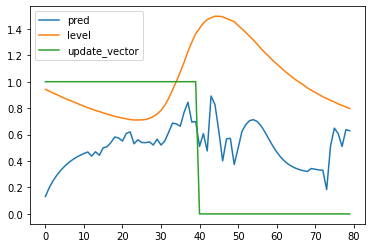

In [ ]:
# make a prediction
plt.plot(dartcom_rain, label='dartcom_rain')
plt.plot(radar_rain, label='radar_rain')
plt.legend()
plt.show()
plt.plot(model.predict(x)[0,:,:], label='pred')
plt.plot(y, label='level')
plt.plot(update_vector, label='update_vector')
plt.legend()
plt.show()


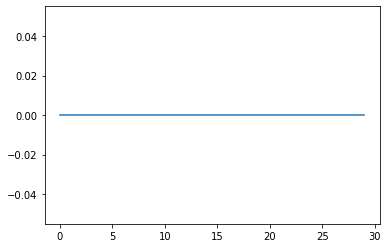

In [ ]:
plt.plot(raw_X[i: i+parameters['num_steps']][0]

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML
images = []
for j in range(0, parameters['num_steps']):
  images.append(colour_map[train_images[i+j,:,:]])


# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 100), ylim=(0, 100))
im=plt.imshow(images[0])
plt.imshow(dart_catchment_mask, cmap='Greys', alpha=0.5)


def init():
    im.set_data(images[0])
    return [im]

def animate(idx):
    im.set_array(images[idx+1])
    return [im]


anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=parameters['num_steps']-1, interval=200)

plt.close()
# this part makes it work on Colab
rc('animation', html='jshtml')
anim